# Smart Quark Project

## Install dependencies

In [ ]:
!pip install pandas matplotlib openpyxl xgboost

# Extract and load data

### Setup datasource and pandas defaults

In [ ]:
from google.colab import drive

import pandas as pd

drive.mount('/content/drive')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)


Mounted at /content/drive


## Wind power plants data

### Load data from datasource

In [3]:
MODEL_TYPE = 'WIND'
d1 = pd.read_excel('/content/drive/MyDrive/ROW_DATA/Unit1_fin.xlsx')
d2 = pd.read_excel('/content/drive/MyDrive/ROW_DATA/Unit2_fin.xlsx')
d3 = pd.read_excel('/content/drive/MyDrive/ROW_DATA/Unit3_fin.xlsx')
d4 = pd.read_excel('/content/drive/MyDrive/ROW_DATA/Unit4_fin.xlsx')
d5 = pd.read_excel('/content/drive/MyDrive/ROW_DATA/Unit5_fin.xlsx')
d6 = pd.read_excel('/content/drive/MyDrive/ROW_DATA/Unit6_fin.xlsx')
d7 = pd.read_excel('/content/drive/MyDrive/ROW_DATA/Unit7_fin.xlsx')
solar = pd.read_excel('/content/drive/MyDrive/ROW_DATA/Unit8_fin.xlsx')

dfs = [d1, d2, d3, d4, d5, d6, d7]

### Transform loaded dataframes

In [4]:
d2.rename(columns = {'Unnamed: 20':'Service'}, inplace = True)
d6.rename(columns = {'Unnamed: 20':'Service'}, inplace = True)

d2['Service'].replace('Service', 1, inplace=True)
d2['Service']= d2['Service'].fillna(0)
d6['Service'].replace('Service', 1, inplace=True)
d6['Service']= d2['Service'].fillna(0)

d1['Service'] = 0
d3['Service'] = 0
d4['Service'] = 0
d5['Service'] = 0
d7['Service'] = 0

### Merge all dataframes into one dataset

In [50]:
orignal_dataset = pd.concat([d1, d2, d3, d4, d5, d6, d7])
dataset = pd.concat([d1, d2, d3, d4, d5, d6, d7])
dataset['MaxLimit'] = dataset.apply(lambda x: x['ins_cap MW'] if x['Limitation to MW'] in ['NO', 'No', float('nan')] else min(x['ins_cap MW'], x['Limitation to MW']),axis=1)
dataset.head(1)

,wind_plant,ins_cap MW,Limitation to MW,date_from,date_to,utc,wind_speed (m/s),wind_dir,temp,pressure,latitude,longitude,Turbine Model,Tower Height,Rotor Diameter,Production Year,START m/s,STOP m/s,Forecast(mwh),Real Prod(mwh),Service,MaxLimit
0,Unit1,1.3,NO,2023-01-03,2023-01-03 01:00:00,UTC+0200,4.8,228,2.2,992,48.212883,27.696193,NORDEX N60,69,60,1999,2.5,25,NaN,NaN,0.0,1.3


### Encode Turbine model using sklearn LabelEncodel

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
dataset['Turbine Model'] = label_encoder.fit_transform(dataset['Turbine Model'])

### Remove redundant columns and drop NA values

In [7]:
dataset.drop(['ins_cap MW', 'Limitation to MW','date_from',	'date_to','wind_plant',	'utc', 'Forecast(mwh)','latitude',	'longitude'], axis=1, inplace=True)
dataset.dropna(inplace=True)

### Filter data for training

In [75]:
X = dataset[['wind_speed (m/s)', 'wind_dir', 'temp', 'pressure', 'Turbine Model',
       'Tower Height', 'Rotor Diameter', 'Production Year', 'START m/s',
       'STOP  m/s', 'Service', 'MaxLimit']]

Y = dataset["Real Prod(mwh)"]

## Solar data

### Read solar power plant data

In [56]:
MODEL_TYPE = 'SOLAR'
solar_df = pd.read_excel('/content/drive/MyDrive/Unit8_fin_.xlsx')
solar_df.head(1)

,PVSolarPlant,InsCap(MW),From Year,From Time,To Year,To Time,UTC offset(HHmm),latitude,longitude,Forecast (mwh),Real Prod(mwh),Total installed capacity KW,Nr_modules,Module capacity W,Model,Nr_inverters,Inverter capacity KW,Inverter,Tracker_type,Orientation
0,Unit8,1.1MW,2023-07-01,00:00,2023-07-01,01:00,UTC+3,46.953021,28.755979,NaN,0.0,1100,1834,600,600W Risen 120-8-600M,9,110,GROWATT MAX 110 KTL3-X LV,fixed panels,South-West


In [57]:
import requests

response = requests.get('https://api.open-meteo.com/v1/forecast?latitude=46.953021&longitude=28.755979&hourly=precipitation_probability,cloudcover,uv_index,is_day&windspeed_unit=ms&timezone=auto&start_date=2023-07-01&end_date=2023-07-31')
weather_data = response.json()

weather_df = pd.DataFrame.from_dict(weather_data['hourly'])
weather_df.head(1)

,time,precipitation_probability,cloudcover,uv_index,is_day
0,2023-07-01T00:00,0,0,0.0,0


In [58]:
solar_base_dataset = pd.merge(solar_df, weather_df, left_index=True, right_index=True)

solar_dataset = solar_base_dataset[[
    'time',
    'InsCap(MW)',
    'Total installed capacity KW',
    'Nr_modules',
    'Module capacity W',
    'Model',
    'Nr_inverters',
    'Inverter capacity KW',
    'Inverter',
    'Tracker_type',
    'Orientation',
    'precipitation_probability',
    'cloudcover',
    'uv_index',
    'is_day',
    'Real Prod(mwh)'
    ]]
solar_dataset.head(1)

,time,InsCap(MW),Total installed capacity KW,Nr_modules,Module capacity W,Model,Nr_inverters,Inverter capacity KW,Inverter,Tracker_type,Orientation,precipitation_probability,cloudcover,uv_index,is_day,Real Prod(mwh)
0,2023-07-01T00:00,1.1MW,1100,1834,600,600W Risen 120-8-600M,9,110,GROWATT MAX 110 KTL3-X LV,fixed panels,South-West,0,0,0.0,0,0.0


In [59]:

label_encoder = LabelEncoder()

solar_dataset['InsCap(MW)'] = 1.1 # TODO change to proper conversion
solar_dataset['Model'] = label_encoder.fit_transform(solar_dataset['Model'])
solar_dataset['Inverter'] = label_encoder.fit_transform(solar_dataset['Inverter'])
solar_dataset['Tracker_type'] = label_encoder.fit_transform(solar_dataset['Tracker_type'])
solar_dataset['Orientation'] = label_encoder.fit_transform(solar_dataset['Orientation'])
solar_dataset

<ipython-input-59-95f404b5c363>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_dataset['InsCap(MW)'] = 1.1 # TODO change to proper conversion
<ipython-input-59-95f404b5c363>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_dataset['Model'] = label_encoder.fit_transform(solar_dataset['Model'])
<ipython-input-59-95f404b5c363>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,time,InsCap(MW),Total installed capacity KW,Nr_modules,Module capacity W,Model,Nr_inverters,Inverter capacity KW,Inverter,Tracker_type,Orientation,precipitation_probability,cloudcover,uv_index,is_day,Real Prod(mwh)
0,2023-07-01T00:00,1.1,1100,1834,600,0,9,110,0,0,0,0,0,0.0,0,0.000
1,2023-07-01T01:00,1.1,1100,1834,600,0,9,110,0,0,0,0,6,0.0,0,0.000
2,2023-07-01T02:00,1.1,1100,1834,600,0,9,110,0,0,0,0,0,0.0,0,0.000
3,2023-07-01T03:00,1.1,1100,1834,600,0,9,110,0,0,0,0,10,0.0,0,0.000
4,2023-07-01T04:00,1.1,1100,1834,600,0,9,110,0,0,0,0,32,0.0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2023-07-31T19:00,1.1,1100,1834,600,0,9,110,0,0,0,60,100,0.6,1,0.022
740,2023-07-31T20:00,1.1,1100,1834,600,0,9,110,0,0,0,63,100,0.2,1,0.000
741,2023-07-31T21:00,1.1,1100,1834,600,0,9,110,0,0,0,65,100,0.0,0,0.000
742,2023-07-31T22:00,1.1,1100,1834,600,0,9,110,0,0,0,65,100,0.0,0,0.000


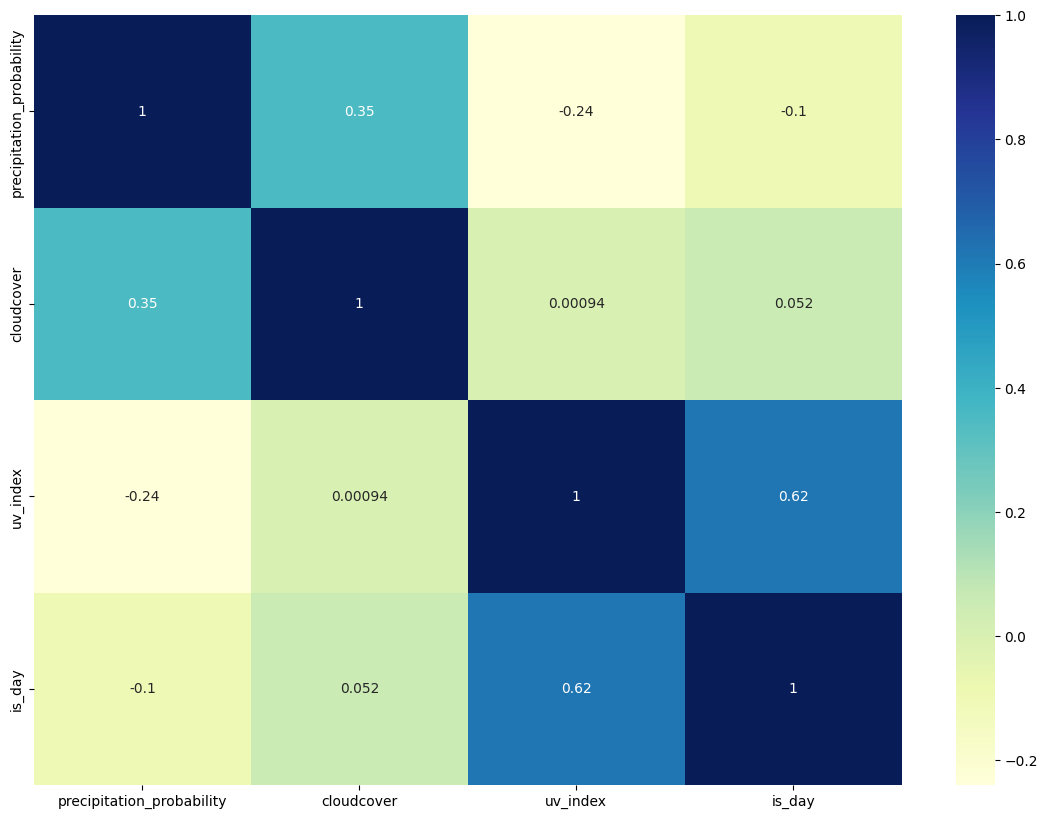

In [60]:
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb

corr = solar_dataset[[
    'precipitation_probability',
    'cloudcover',
    'uv_index',
    'is_day']].corr()

plt.figure(figsize=(14,10))
dataplot = sb.heatmap(corr, cmap="YlGnBu", annot=True)

mp.show()

In [61]:
Y = solar_dataset['Real Prod(mwh)']
X = solar_dataset.drop([ 'Real Prod(mwh)', 'time'], axis=1)

# Training stage

## Import models and utils

In [62]:
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    ElasticNet,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor,
)

from xgboost import (
    XGBRegressor,
)

from sklearn.neural_network import (
    MLPRegressor,
)

# Function and nodules for data analysis and nodel evaluation

from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
)

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error
)

from sklearn.feature_selection import (
    chi2,
    f_regression,
    SelectKBest,
)

# Function and modules for deep learning models

from keras.models import (
    Sequential,
)
from keras.layers import (
    Dense,
    LSTM,
)
import matplotlib.pyplot as plt

## Dataset preparation

### Setting up dataset preprocess parameters

In [63]:
validation_size = 0.2

num_folds = 10
scoring = 'neg_median_absolute_error'

### Train/test splitting

In [64]:
X_train, Y_train = X, Y

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size)

## Setting up POC models

In [66]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor()))

#BoostingMethods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
#Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))
models.append(('XGB', XGBRegressor()))

## Models training, scoring and comparison

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

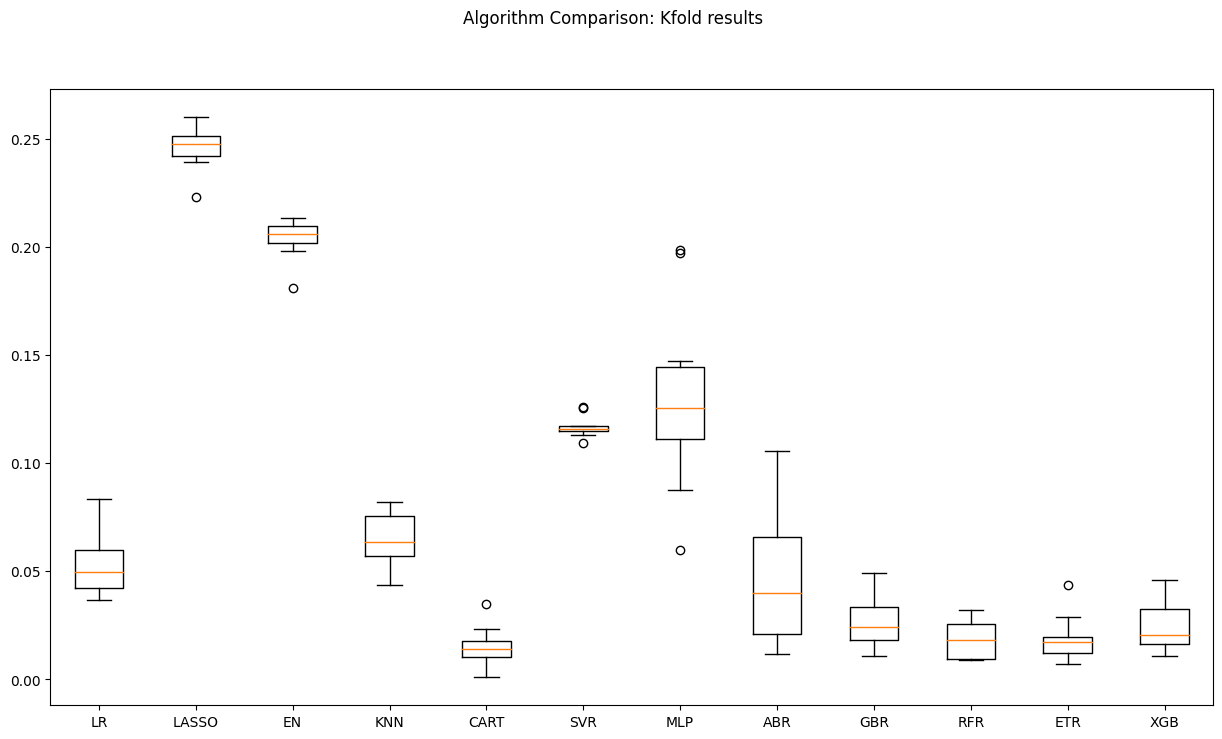

In [67]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    kfold = KFold(n_splits=num_folds)
    cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    res = model.fit(X_train, Y_train)

    # Train results

    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results

    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

# Let's compare the algorithms by looking at the cross validation results:

# Cross validation results

fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot (kfold_results)
ax.set_xticklabels (names)
fig.set_size_inches (15,8)
plt.show()

### Models results against median of test sample results

In [69]:
test_results < Y_test.median()

array([ True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True])

In [36]:
with open('/content/drive/MyDrive/models/ETR.pickle','rb') as f:
    res = pickle.load(f)
test_result = mean_absolute_error(res.predict(X_test), Y_test)
print("", test_result)

with open('/content/drive/MyDrive/models/MLP.pickle','rb') as f:
    res = pickle.load(f)
test_result = mean_absolute_error(res.predict(X_test), Y_test)
test_result

0.2527943019068534

In [71]:
X.columns

Index(['InsCap(MW)', 'Total installed capacity KW', 'Nr_modules',
       'Module capacity W', 'Model', 'Nr_inverters', 'Inverter capacity KW',
       'Inverter', 'Tracker_type', 'Orientation', 'precipitation_probability',
       'cloudcover', 'uv_index', 'is_day'],
      dtype='object')

## Save Models

In [68]:
import pickle
import os

if not os.path.exists('/content/drive/MyDrive/models/'):
    os.mkdir('/content/drive/MyDrive/models/')
for name, model in models:
    with open(f'/content/drive/MyDrive/models/{MODEL_TYPE}_{name}.pickle', 'wb') as f:
        pickle.dump(model, f)

# API design

## Wind model

In [80]:
X.columns

Index(['wind_speed (m/s)', 'wind_dir', 'temp', 'pressure', 'Turbine Model',
       'Tower Height', 'Rotor Diameter', 'Production Year', 'START m/s',
       'STOP  m/s', 'Service', 'MaxLimit'],
      dtype='object')

In [86]:
import requests

c1 = [46.953021, 28.755979]

c2 = [48.212883, 27.696193]
def get_weather_forecast(lat: float, long: float):
    resp = requests.get(f'https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={long}&hourly=temperature_2m,surface_pressure,windspeed_10m,winddirection_10m&windspeed_unit=ms&timezone=auto')
    df = pd.DataFrame.from_dict(resp.json()['hourly'])
    df.rename(columns={'temperature_2m': 'temp', 'surface_pressure':'pressure',	'windspeed_10m':'wind_speed (m/s)',	'winddirection_10m':'wind_dir'}, inplace=True)
    df.drop(['time'], axis=1, inplace=True)
    return df
print(get_weather_forecast(*c1))
print(get_weather_forecast(*c2))

     temp  pressure  wind_speed (m/s)  wind_dir
0    17.2    1013.6              0.89        63
1    16.3    1013.8              0.98        66
2    15.4    1014.0              0.95        72
3    14.3    1013.7              1.02        79
4    13.7    1014.2              0.91        84
..    ...       ...               ...       ...
163  21.4    1012.4              2.30        90
164  20.2    1012.7              1.71        83
165  19.1    1012.8              1.24        76
166  18.2    1012.6              0.98        66
167  17.4    1012.4              0.78        50

[168 rows x 4 columns]
     temp  pressure  wind_speed (m/s)  wind_dir
0    15.9     994.0              1.51        82
1    14.8     994.0              1.22        81
2    13.8     994.1              1.12        80
3    12.9     993.7              1.22        81
4    12.6     994.0              1.20        90
..    ...       ...               ...       ...
163  20.0     992.8              2.86       115
164  18.3     99

In [77]:
X.columns

Index(['wind_speed (m/s)', 'wind_dir', 'temp', 'pressure', 'Turbine Model',
       'Tower Height', 'Rotor Diameter', 'Production Year', 'START m/s',
       'STOP  m/s', 'Service', 'MaxLimit'],
      dtype='object')